| **Chapter**                   | 8:  Spatial dynamics of epidemics                                                                                           |
| ----------------------------- |-----------------------------------------------------------------------------------------------------------------------------|
| **Computational Note**        | 8.x: Placing testing sites in Alexandria, VA                                                                                |
| **Package prerequisites**     | [osmnx](https://osmnx.readthedocs.io/en/stable/), [igraph](https://igraph.org/python/), [spopt](https://pysal.org/spopt/)   |


# Placing testing sites in Alexandria, VA

In [161]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import osmnx
import igraph as ig
from spopt.locate import PMedian
import pulp
import networkx as nx
import random
import warnings
from tqdm import auto as tqdm

SMALL_SIZE = 5
matplotlib.rc("font", size=SMALL_SIZE)
matplotlib.rc("axes", titlesize=SMALL_SIZE)

random.seed(1234)

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}


In [162]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay" -p pysal,cplex,spopt

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

pysal: 2.6.0
cplex: not installed
spopt: 0.4.1

tqdm      : 4.64.0
numpy     : 1.21.6
igraph    : 0.9.9
pulp      : 2.6.0
osmnx     : 1.2.0
networkx  : 2.8.4
seaborn   : 0.11.2
pandas    : 1.4.2
matplotlib: 3.5.2



# Setting parameters

In [163]:
location = "Alexandria, VA"
p = 4

# Importing map data

## Importing the connectivity graph

In [164]:
%%time
graph = osmnx.graph_from_place(location, network_type="drive")

CPU times: user 4.54 s, sys: 379 ms, total: 4.91 s
Wall time: 5.26 s


/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


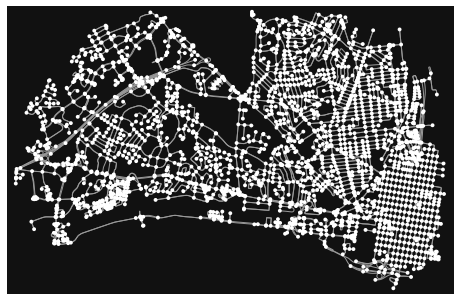

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [165]:
osmnx.plot_graph(graph)

## Converting the connectivity graph to `igraph`

In [166]:
osm_ids = list(graph.nodes)
graph = nx.relabel.convert_node_labels_to_integers(graph)

osm_id_vals = {k: v for k, v in zip(graph.nodes, osm_ids)}
nx.set_node_attributes(graph, osm_id_vals, "osmid")

i_graph = ig.Graph(directed=True)
i_graph.add_vertices(graph.nodes)
i_graph.add_edges(graph.edges())
i_graph.vs["osmid"] = osm_ids
i_graph.es["length"] = list(nx.get_edge_attributes(graph, "length").values())

## Importing building footprints

In [167]:
building_filter = ["yes", "dormitory", "terrace", "apartments", "residential", "house", "semidetached_house", "detached", "condominium"]

In [168]:
%%time
buildings = osmnx.geometries.geometries_from_place(location, tags={"building": True})[["geometry", "building"]]
buildings = buildings[buildings.building.isin(building_filter)]
buildings.geometry = buildings.geometry.to_crs(6350)
buildings = buildings[buildings.geometry.apply(lambda x: x.type != "Point")]

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


CPU times: user 3.91 s, sys: 442 ms, total: 4.35 s
Wall time: 4.61 s


In [169]:
buildings["nearest_node"] = osmnx.distance.nearest_nodes(graph, buildings.geometry.centroid.x, buildings.geometry.centroid.y)
buildings = buildings.reset_index()

In [170]:
len(buildings)

25706

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


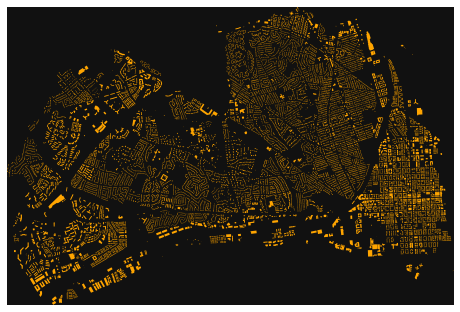

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [171]:
osmnx.plot_footprints(buildings)

## Importing footprints for eligible sites

In [172]:
%%time
eligible_sites = osmnx.geometries.geometries_from_place(location, tags={"amenity": ["hospital", "community_centre", "parking", "conference_centre", "events_venue"]})[["geometry"]]
eligible_sites.geometry = eligible_sites.geometry.to_crs(6350)
eligible_sites["nearest_node"] = osmnx.distance.nearest_nodes(graph, eligible_sites.geometry.centroid.x, eligible_sites.geometry.centroid.y)
eligible_sites = eligible_sites[eligible_sites.geometry.area > 10000]
eligible_sites = eligible_sites[eligible_sites.geometry.apply(lambda x: x.type != "Point")]
eligible_sites = eligible_sites.reset_index()
eligible_sites.geometry = eligible_sites.geometry.to_crs(4326)

CPU times: user 547 ms, sys: 25.7 ms, total: 573 ms
Wall time: 565 ms


In [173]:
len(eligible_sites)

43

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


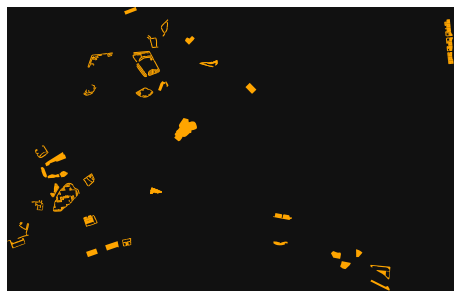

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [174]:
osmnx.plot_footprints(eligible_sites)

# Location optimisation

## Calculating cost matrix

In [175]:
def get_distance(source_node, destination_node) -> float:
   return sum(list(map(lambda x: i_graph.es[x]["length"], i_graph.get_shortest_paths(v=source_node, to=destination_node, weights="length", output="epath")[0])))

In [176]:
cost_matrix = np.zeros(shape=(len(buildings), len(eligible_sites)), dtype=float)

In [177]:
%%time

for i in tqdm.notebook_trange(len(buildings)):
    for j in range(len(eligible_sites)):
        cost_matrix[i, j] = get_distance(buildings.loc[i, "nearest_node"], eligible_sites.loc[j, "nearest_node"])
        cost_matrix_idx = buildings.index[i]

  0%|          | 0/25706 [00:00<?, ?it/s]

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_90026/3933603623.py:2: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:441
  return sum(list(map(lambda x: i_graph.es[x]["length"], i_graph.get_shortest_paths(v=source_node, to=destination_node, weights="length", output="epath")[0])))


CPU times: user 14min 49s, sys: 20.4 s, total: 15min 10s
Wall time: 15min 15s


## Filtering buildings and cost matrix to eliminate unreachable locations

In [178]:
cost_df = pd.DataFrame(cost_matrix, index=buildings.index)
cost_df = cost_df.loc[(cost_df != 0).any(axis=1)]

In [179]:
buildings = buildings.iloc[cost_df.index.to_list()]

## $p$-median optimisation

In [180]:
cost_matrix = cost_df.to_numpy()

In [181]:
pmedian = PMedian.from_cost_matrix(cost_matrix, weights=buildings.geometry.area.to_numpy(), p_facilities=p)

In [182]:
%%time

pmedian.solve(pulp.COIN_CMD())

Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  6 2022 

command line - cbc /var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/c1d0e4e61f8e487482d35f67955d8113-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/c1d0e4e61f8e487482d35f67955d8113-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1105946 COLUMNS
At line 7491166 RHS
At line 8597108 BOUNDS
At line 9677957 ENDATA
Problem MODEL has 1105941 rows, 1080848 columns and 3242458 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 6.10611e+09 - 2281.99 seconds
Cgl0004I processed model has 1105941 rows, 1080848 columns (1080848 integer (1080848 of which binary)) and 3242458 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 6.10611e+09
Cbc0038I Before mini branch and bound, 1080848 integers at bound fixed and 0 continu

In [183]:
pmedian.facility_client_array()
pmedian.client_facility_array()

In [184]:
selected_facilities = np.unique(pmedian.cli2fac).tolist()

In [185]:
selected_facilities

[0, 13, 31, 34]

In [186]:
buildings["assigned_facility"] = list(map(lambda x: x[0], pmedian.cli2fac))

In [187]:
conversion = dict(zip(buildings.assigned_facility.unique(), list("ABCDEFGHIJKLMNOPQ")[:len(buildings.assigned_facility.unique())]))

In [188]:
buildings["assigned_facility_label"] = buildings.assigned_facility.apply(lambda x: conversion[x])

In [189]:
selected_sites = eligible_sites.iloc[selected_facilities]
selected_sites["label"] = selected_sites.index.map(lambda x: conversion[x])

buildings["assigned_facility_distance"] = buildings.apply(lambda x: get_distance(x.nearest_node, eligible_sites.iloc[x.assigned_facility].nearest_node), axis=1)

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [190]:
selected_sites

element_type      osmid                                           geometry  \
0           way   27311017  POLYGON ((-77.08667 38.80833, -77.08700 38.808...   
13          way  299868466  POLYGON ((-77.08692 38.80417, -77.08691 38.804...   
31     relation    9869889  POLYGON ((-77.13153 38.81152, -77.13151 38.811...   
34     relation    9899939  POLYGON ((-77.14049 38.80338, -77.14107 38.804...   

    nearest_node label  
0           2689     C  
13          2021     A  
31          1310     B  
34          1291     D

# Plotting results

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_90026/830136134.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  circle_centers = selected_sites.geometry.centroid
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= Loos

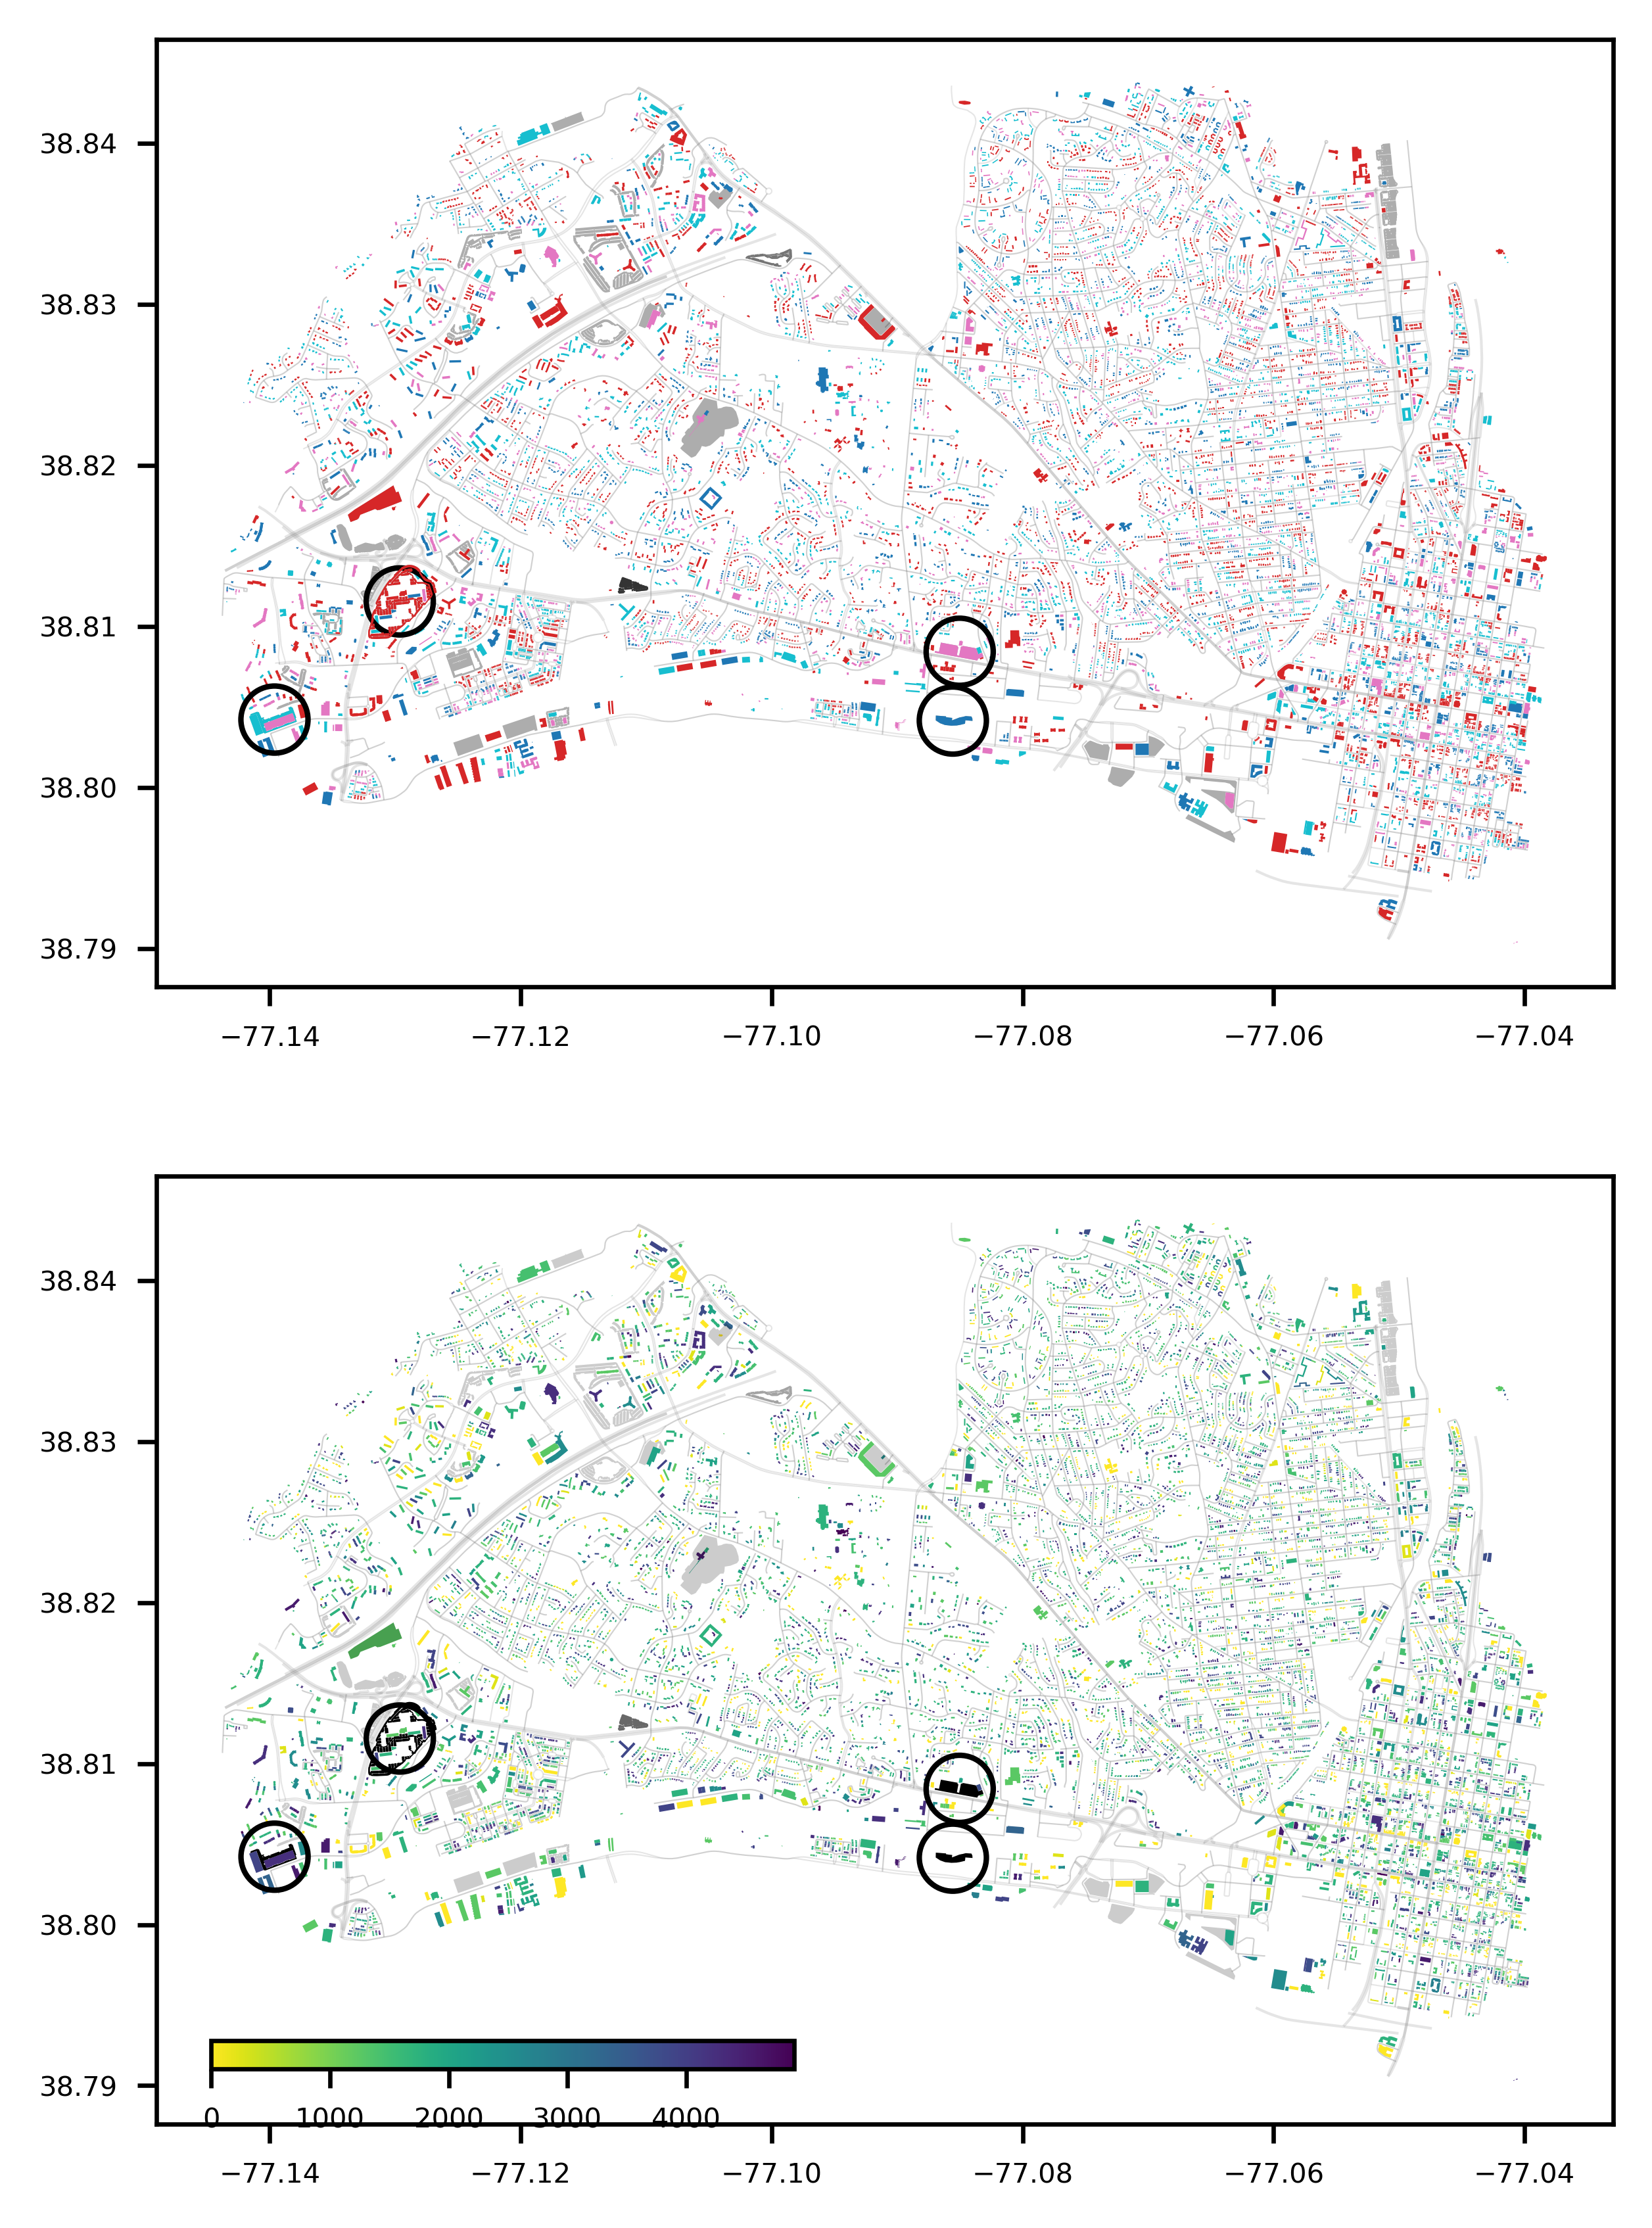

In [191]:
nodes, edges = osmnx.graph_to_gdfs(graph)

buildings_filtered = buildings[(buildings.apply(lambda x: np.min([x.geometry.centroid.distance(site.centroid) for site in selected_sites.geometry]) > 0.002, axis=1)) & (buildings.assigned_facility_distance > 0) & (~buildings.osmid.isin(selected_sites.osmid))]

edges.geometry = edges.geometry.to_crs(4326)
selected_sites.geometry = selected_sites.geometry.to_crs(4326)
buildings_filtered.geometry = buildings_filtered.geometry.to_crs(4326)
eligible_sites.geometry = eligible_sites.geometry.to_crs(4326)

circle_centers = selected_sites.geometry.centroid
circle_centers.reset_index()
circle_size=150
middle_scale = "tab10"
bottom_scale = "viridis_r"

fig = plt.figure(facecolor="w", figsize=(6, 7), dpi=600)
ax = fig.add_subplot(211, axisbelow=True)

arterial_roads = edges.loc[edges.highway.isin(["motorway", "trunk", "primary", "primary_link"])]
secondary_roads = edges.loc[edges.highway.isin(["secondary", "tertiary", "residential"])]

arterial_roads.plot(ax=ax, lw=0.5, color="gray", alpha=0.2, zorder=3)
secondary_roads.plot(ax=ax, lw=0.25, color="gray", alpha=0.2, zorder=3)

eligible_sites.plot(ax=ax, color="k", alpha=0.2, zorder=4)

buildings_filtered.plot("assigned_facility_label", cmap=middle_scale, ax=ax, zorder=5)

eligible_sites.plot(ax=ax, color="k", alpha=0.15, zorder=4)

selected_sites.plot("label", ax=ax, cmap=middle_scale, zorder=9, legend=False)

ax.scatter(circle_centers.x, circle_centers.y, marker="o", edgecolors="k", facecolors="none", s=circle_size, zorder=7)

ax.tick_params(axis="x", labelsize=5)
ax.tick_params(axis="y", labelsize=5)

ax = fig.add_subplot(212, axisbelow=True)

arterial_roads = edges.loc[edges.highway.isin(["motorway", "trunk", "primary", "primary_link"])]
secondary_roads = edges.loc[edges.highway.isin(["secondary", "tertiary", "residential"])]

arterial_roads.plot(ax=ax, lw=0.5, color="gray", alpha=0.2, zorder=3)
secondary_roads.plot(ax=ax, lw=0.25, color="gray", alpha=0.2, zorder=3)

eligible_sites.plot(ax=ax, color="k", alpha=0.2, zorder=4)

selected_sites.plot(ax=ax, color="k", zorder=5)

ax.scatter(circle_centers.x, circle_centers.y, marker="o", edgecolors="k", facecolors="none", s=circle_size, zorder=7)

dist = buildings_filtered.plot("assigned_facility_distance", ax=ax, cmap=bottom_scale, legend=False)

norm = colors.Normalize(vmin=buildings.assigned_facility_distance.min(), vmax=buildings.assigned_facility_distance.max())
cbar = plt.cm.ScalarMappable(norm=norm, cmap=bottom_scale)

ax.tick_params(axis="x", labelsize=5)
ax.tick_params(axis="y", labelsize=5)

axins = inset_axes(ax, width="40%", height="3%", loc="lower left", borderpad=2)

ax_cbar = fig.colorbar(cbar, cax=axins, orientation="horizontal")
axins.tick_params(axis="x", labelsize=3)

plt.xticks(fontsize=SMALL_SIZE)
plt.savefig("testing_site_loc_opt.pdf")